### Patrick Horlaville (260931235) - Problem Set 1 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1b)

A 64-bit machine's floating point format typically is

In [2]:
e_m = 2**(-52)

In [3]:
def deriv(funct, x, delta):

    p1 = 8*(funct(x + delta) - funct(x - delta))
    p2 = funct(x + 2*delta) - funct(x - 2*delta)
    
    deriv = (1/(12*delta))*(p1 - p2)
    
    return deriv

In [4]:
def funct1(x):
    return np.exp(x)

In [5]:
x_t = 10
e_f = e_m
delta_1a = (e_f)**(1/5)

In [6]:
deriv_est_1a = deriv(funct1, x_t, delta_1a)

In [7]:
frac_err_1a = (deriv_est_1a - funct1(x_t))/funct1(x_t)

In [8]:
print('Our estimate for the derivative at x =', x_t, ' for f(x) = exp(x) is', deriv_est_1a, ', which results in a fractional error of', frac_err_1a)

Our estimate for the derivative at x = 10  for f(x) = exp(x) is 22026.465794831664 , which results in a fractional error of 1.132529426763935e-12


So indeed, for f(x) = e^x, the estimate for the optimal delta is at least roughly correct given an error of order 10^(-12) 

In [9]:
def funct2(x):
    return np.exp(0.01*x)

In [10]:
x_t = 10
delta_1b = 100*(e_m**(1/5))

In [11]:
deriv_est_1b = deriv(funct2, x_t, delta_1b)

In [12]:
frac_err_1b = (np.absolute(deriv_est_1b - 0.01*funct2(x_t)))/(0.01*funct2(x_t))

In [13]:
print('Our estimate for the derivative at x =', x_t, ' for f(x) = exp(0.01x) is', deriv_est_1b, ', which results in a fractional error of', frac_err_1b)

Our estimate for the derivative at x = 10  for f(x) = exp(0.01x) is 0.011051709180755005 , which results in a fractional error of 1.332626661646827e-13


Same here, for f(x) = e^(0.01x), the estimate for the optimal delta is at least roughly correct given an error of order 10^(-13) 

# 2)

In [14]:
x_t = 10
d_approx = x_t*(e_m**(1/3))

In [17]:
def third_deriv(funct, x, d):
    
    p1 = funct(x + 2*d) - funct(x - 2*d)
    p2 = funct(x + d) - funct(x - d)
    
    third_d = (p1 - 2*p2)/(2*(d**3))
    
    return third_d

In [115]:
def est_delta(funct, x, d_approx, n):
        
    ds = [0 for i in range(n)]
    third_ds = [0 for i in range(n)]
    
    if n==0:
        opti_delta = d_approx
    
    else:
        ds = [0 for i in range(n+1)]
        third_ds = [0 for i in range(n+1)]
        
        ds[0] = d_approx
        
        for i in range(1, n+1):
            third_ds[i] = third_deriv(funct, x, ds[i-1])
            if third_ds[i] < e_m:
                opti_delta = ds[i-1]
                return opti_delta
            else:
                ds[i] = ((e_m*funct(x))/third_ds[i])**(1/3)
                opti_delta = ds[i]
                    
    return opti_delta

In [132]:
def ndiff(funct, x, full = False):
    
    n = 5
    d_approx = x*(e_m**(1/3))
    
    best_d = est_delta(funct, x, d_approx, n)
    
    deriv = (funct(x + best_d) - funct(x - best_d))/(2*best_d)
    
    th_deriv = third_deriv(funct, x, best_d)
    
    if th_deriv > e_m:
        err = ((e_f**2)*((funct(x))**2)*(third_deriv))**(1/3)
    else:
        err = (e_f)**(2/3)
    
    if full:
        return deriv, err
    else:
        return deriv

In [248]:
ndiff(funct2, 10, full = True)

(0.011051709180999887, 3.666852862501036e-11)

In [251]:
print('Using an example from previous functions, we have an absolute error of', np.abs((0.01*funct2(10)) - ndiff(funct2, 10, full = True)[0]), ' from a predicted value of', ndiff(funct2, 10, full = True)[1])

Using an example from previous functions, we have an absolute error of 2.4340945925516166e-13  from a predicted value of 3.666852862501036e-11


# 3)

In [134]:
data = np.loadtxt("lakeshore.txt")

In [135]:
temperature, voltage, dVdT = np.transpose(data)

Text(0.5, 1.0, 'Temperature as a function of voltage from Lakeshore data')

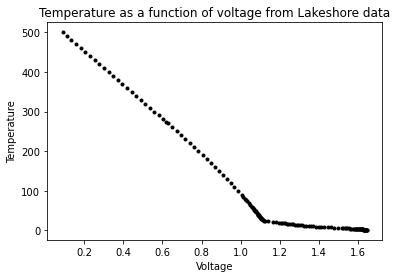

In [137]:
plt.plot(voltage, temperature, '.k')
plt.xlabel('Voltage')
plt.ylabel('Temperature')
plt.title('Temperature as a function of voltage from Lakeshore data')

Here we make use of Jon's cubic_interp.py code snippets

In [264]:
def lakeshore(V, data):
    
    temp, volt, dVdT = np.transpose(data)
    
    volt = volt[::-1]
    temp = temp[::-1]
    
    if type(V) == type(np.array([])):
        pass
    else: 
        V = np.array([V])
        
    t_interp = np.zeros(len(V))
    tot_err = np.zeros(len(V))
    
    for i in range(len(V)):    
        ind = np.max(np.where(V[i] >= volt)[0])
        v_use = volt[ind - 1:ind + 3]
        t_use = temp[ind - 1:ind + 3]
        pars = np.polyfit(v_use, t_use, 3)
        pred = np.polyval(pars, V[i])
        t_interp[i] = pred
        
        mins = np.sort(np.abs(V[i] - v_use))
        h_est = mins[0]
        if h_est < e_m:
            h_est = mins[1]
            trunc_err = (h_est)**4
            round_err = (e_f)*(np.abs(t_interp[i]/h_est))
            tot_err[i] = trunc_err + round_err
        else:
            trunc_err = (h_est)**4
            round_err = (e_f)*(t_interp[i]/h_est)
            tot_err[i] = trunc_err + round_err
                
    
    return t_interp, tot_err

In [229]:
v_interp = np.linspace(voltage[::-1][1], voltage[::-1][-2], 100)

In [230]:
t_interp, err_interp = lakeshore(v_interp, data)

<ipython-input-230-5b1865521a34>:1: RankWarning: Polyfit may be poorly conditioned
  t_interp, err_interp = lakeshore(v_interp, data)


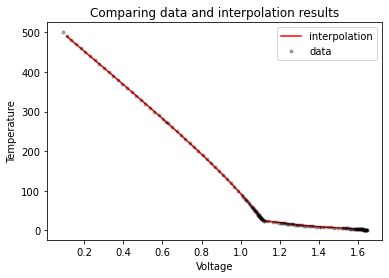

In [401]:
plt.plot(v_interp, t_interp, '-r', label = 'interpolation')
plt.plot(voltage, temperature, '.k', alpha = 0.3, label = 'data')
plt.xlabel('Voltage')
plt.ylabel('Temperature')
plt.title('Comparing data and interpolation results')
plt.legend()

Text(0.5, 1.0, 'Distribution of errors from our interpolation')

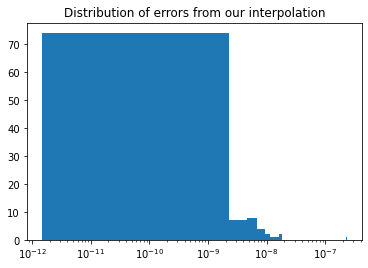

In [459]:
plt.hist(err_interp, bins = 100)
plt.xscale('log')
plt.title('Distribution of errors from our interpolation')

So our estimated error on each of our interpolated points is of order 10^(-10)

# 4)

Fist, fit over the cosine function. We will fit over the interval:

In [410]:
x_interp1 = np.linspace(-np.pi/2, np.pi/2, 10)

In [411]:
from scipy import interpolate

In [412]:
x_cos = np.linspace(-np.pi/2, np.pi/2, 8)
y_cos = np.cos(x_cos)

Text(0.5, 1.0, 'Real cosine function')

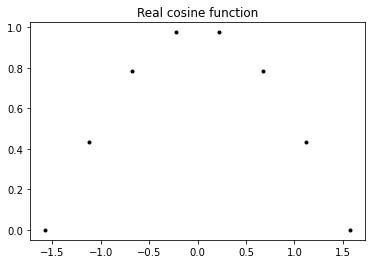

In [413]:
plt.plot(x_cos, y_cos, '.k')
plt.title('Real cosine function')

Perform polynomial interpolation (here, a cubic polynomial fit)

In [414]:
def cubic_interp(x_interp, x, y):
    
    if type(x_interp) == type(np.array([])):
        pass
    else: 
        x_interp = np.array([x_interp])
     
    y_interp = np.zeros(len(x_interp))
    
    for i in range(len(x_interp)):    
        ind = np.max(np.where(x_interp[i] >= x)[0])
        if ind == 0:
            x_use = x[0:ind + 3]
            y_use = y[0:ind + 3]
        else:    
            x_use = x[ind - 1:ind + 3]
            y_use = y[ind - 1:ind + 3]
        
        pars = np.polyfit(x_use, y_use, 3)
        pred = np.polyval(pars, x_interp[i])
        y_interp[i] = pred
    
    
    return y_interp

In [415]:
y_cubcos = cubic_interp(x_interp1, x_cos, y_cos)

<ipython-input-415-cd798768d9ec>:1: RankWarning: Polyfit may be poorly conditioned
  y_cubcos = cubic_interp(x_interp1, x_cos, y_cos)
<ipython-input-415-cd798768d9ec>:1: RankWarning: Polyfit may be poorly conditioned
  y_cubcos = cubic_interp(x_interp1, x_cos, y_cos)
<ipython-input-415-cd798768d9ec>:1: RankWarning: Polyfit may be poorly conditioned
  y_cubcos = cubic_interp(x_interp1, x_cos, y_cos)
<ipython-input-415-cd798768d9ec>:1: RankWarning: Polyfit may be poorly conditioned
  y_cubcos = cubic_interp(x_interp1, x_cos, y_cos)


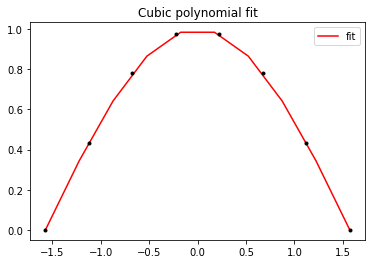

In [416]:
plt.plot(x_interp1, y_cubcos, 'r', label = 'fit')
plt.plot(x_cos, y_cos, '.k')
plt.title('Cubic polynomial fit')
plt.legend()

In [417]:
print('Cubic polynomial fit has a standard deviation of', np.std(y_cubcos - np.cos(x_interp1)))

Cubic polynomial fit has a standard deviation of 0.001142427526653603


Then, we perform a cubic spline fit

In [418]:
spln_cos = interpolate.splrep(x_cos, y_cos)
y_cos_spl = interpolate.splev(x_interp1, spln_cos)

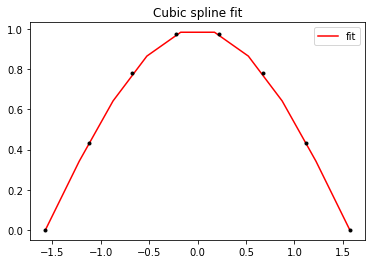

In [419]:
plt.plot(x_interp1, y_cos_spl, 'r', label = 'fit')
plt.plot(x_cos, y_cos, '.k')
plt.title('Cubic spline fit')
plt.legend()

In [420]:
print('Cubic spline fit has a standard deviation of', np.std(y_cos_spl - np.cos(x_interp1)))

Cubic spline fit has a standard deviation of 0.0001360105051125853


Finally, we perform a rational fit

Here we make use of code snippets as made in class

In [421]:
def rat_eval(p, q, x):
    top = 0
    
    for i in range(len(p)):
        top = top+p[i]*x**i
    bot = 1
    for i in range(len(q)):
        bot = bot + q[i]*x**(i + 1)
        
    return top/bot

def rat_fit(x, y, n, m):
    
    assert(len(x) == n + m - 1)
    assert(len(y) == len(x))
    
    mat = np.zeros([n + m - 1, n + m - 1])
    
    for i in range(n):
        mat[:,i] = x**i
    for i in range(1,m):
        mat[:,i - 1 + n] = -y*x**i
        

    pars = np.dot(np.linalg.inv(mat), y)
        
    p = pars[:n]
    q = pars[n:]
    
    return p,q

In [422]:
n = 4
m = 5

In [423]:
p_cos, q_cos = rat_fit(x_cos, y_cos, n, m)
pred_cos = rat_eval(p_cos, q_cos, x_interp1)

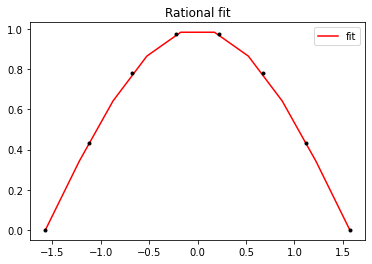

In [424]:
plt.title('Rational fit')
plt.plot(x_interp1, pred_cos, 'r', label = 'fit')
plt.plot(x_cos, y_cos, '.k')
plt.legend()

In [425]:
print('Rational fit has a standard deviation of', np.std(pred_cos - np.cos(x_interp1)))

Rational fit has a standard deviation of 1.8463778585426775e-05


Now with the Lorentzian function:

In [426]:
def lor(x):
    return 1/(1 + (x)**2)

We will interpolate on the interval:

In [427]:
x_interp2 = np.linspace(-1, 1, 10)

In [428]:
x_lor = np.linspace(-1, 1, 8)
y_lor = np.cos(x_lor)

Text(0.5, 1.0, 'Real Lorentzian function')

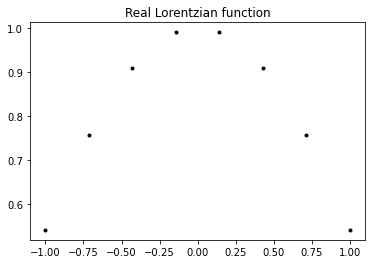

In [429]:
plt.plot(x_lor, y_lor, '.k')
plt.title('Real Lorentzian function')

First, the cubic polynomial fit

In [430]:
y_cublor = cubic_interp(x_interp2, x_lor, y_lor)

<ipython-input-430-effb2cb6b18c>:1: RankWarning: Polyfit may be poorly conditioned
  y_cublor = cubic_interp(x_interp2, x_lor, y_lor)
<ipython-input-430-effb2cb6b18c>:1: RankWarning: Polyfit may be poorly conditioned
  y_cublor = cubic_interp(x_interp2, x_lor, y_lor)
<ipython-input-430-effb2cb6b18c>:1: RankWarning: Polyfit may be poorly conditioned
  y_cublor = cubic_interp(x_interp2, x_lor, y_lor)
<ipython-input-430-effb2cb6b18c>:1: RankWarning: Polyfit may be poorly conditioned
  y_cublor = cubic_interp(x_interp2, x_lor, y_lor)


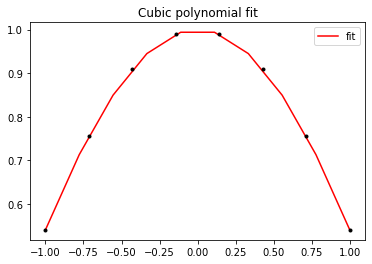

In [431]:
plt.plot(x_interp2, y_cublor, 'r', label = 'fit')
plt.plot(x_lor, y_lor, '.k')
plt.title('Cubic polynomial fit')
plt.legend()

In [432]:
print('Cubic polynomial fit has a standard deviation of', np.std(y_cublor - lor(x_interp2)))

Cubic polynomial fit has a standard deviation of 0.031124041451607506


Then, we perform a cubic spline fit

In [433]:
spln_lor = interpolate.splrep(x_lor, y_lor)
y_lor_spl = interpolate.splev(x_interp2, spln_lor)

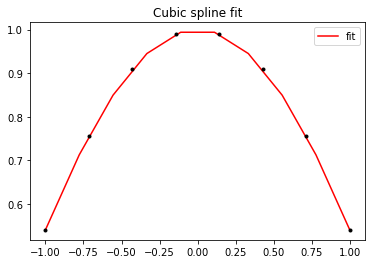

In [434]:
plt.plot(x_interp2, y_lor_spl, 'r', label = 'fit')
plt.plot(x_lor, y_lor, '.k')
plt.title('Cubic spline fit')
plt.legend()

In [435]:
print('Cubic spline fit has a standard deviation of', np.std(y_lor_spl - lor(x_interp2)))

Cubic spline fit has a standard deviation of 0.031022580690215518


Finally, we perform a rational fit

In [436]:
p_lor, q_lor = rat_fit(x_lor, y_lor, n, m)
pred_lor = rat_eval(p_lor, q_lor, x_interp2)

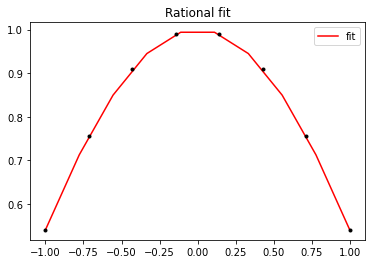

In [437]:
plt.title('Rational fit')
plt.plot(x_interp2, pred_lor, 'r', label = 'fit')
plt.plot(x_lor, y_lor, '.k')
plt.legend()

In [438]:
print('Rational fit has a standard deviation of', np.std(pred_lor - lor(x_interp2)))

Rational fit has a standard deviation of 0.0310168740894946


Let's try using a rational fit with pinv now:

In [439]:
def rat_fit_pinv(x, y, n, m):
    
    assert(len(x) == n + m - 1)
    assert(len(y) == len(x))
    
    mat = np.zeros([n + m - 1, n + m - 1])
    
    for i in range(n):
        mat[:,i] = x**i
    for i in range(1,m):
        mat[:,i - 1 + n] = -y*x**i
    
    pars = np.dot(np.linalg.pinv(mat), y)
    
    p = pars[:n]
    q = pars[n:]
    
    return p,q

In [440]:
p_lorp, q_lorp = rat_fit_pinv(x_lor, y_lor, n, m)
pred_lorp = rat_eval(p_lorp, q_lorp, x_interp2)

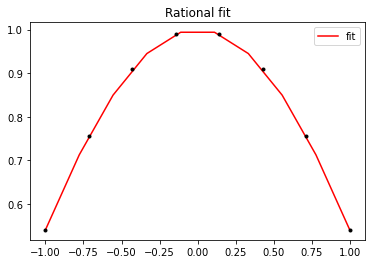

In [441]:
plt.title('Rational fit')
plt.plot(x_interp2, pred_lorp, 'r', label = 'fit')
plt.plot(x_lor, y_lor, '.k')
plt.legend()

In [442]:
print('Rational fit has a standard deviation of', np.std(pred_lorp - lor(x_interp2)))

Rational fit has a standard deviation of 0.031016874089479906


In [456]:
print('Numerator coefficients:')
for i, j in enumerate(p_lorp):
    print('order = ', i ,':', p_lor[i], 'from inv; ', j, 'from pinv')
    
    
print('Denominator coefficients:')
for i, j in enumerate(q_lorp):
    print('order = ', i ,':', q_lor[i], 'from inv; ', j, 'from pinv')

Numerator coefficients:
order =  0 : 0.9999997854671383 from inv;  0.9999997854709735 from pinv
order =  1 : 5.4569682106375694e-12 from inv;  -3.637978807091713e-12 from pinv
order =  2 : -0.4059329669241851 from inv;  -0.405932966923956 from pinv
order =  3 : -1.8189894035458565e-12 from inv;  0.0 from pinv
Denominator coefficients:
order =  0 : 3.637978807091713e-12 from inv;  1.8189894035458565e-12 from pinv
order =  1 : 0.09405470796505 from inv;  0.09405470796504822 from pinv
order =  2 : 0.0 from inv;  -2.2737367544323206e-13 from pinv
order =  3 : 0.005453497154482179 from inv;  0.005453497154480402 from pinv
